In [25]:
from keras.datasets import mnist
from keras.layers import Conv2D, AveragePooling2D, Flatten, ReLU, Dense, Input, LeakyReLU, Reshape, \
                            BatchNormalization, Dropout

from tqdm import tqdm, tqdm_notebook
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, LabelBinarizer 
import numpy as np
import matplotlib.pyplot as plt

## GAN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_62 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_389 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_255 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_390 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_256 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_391 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

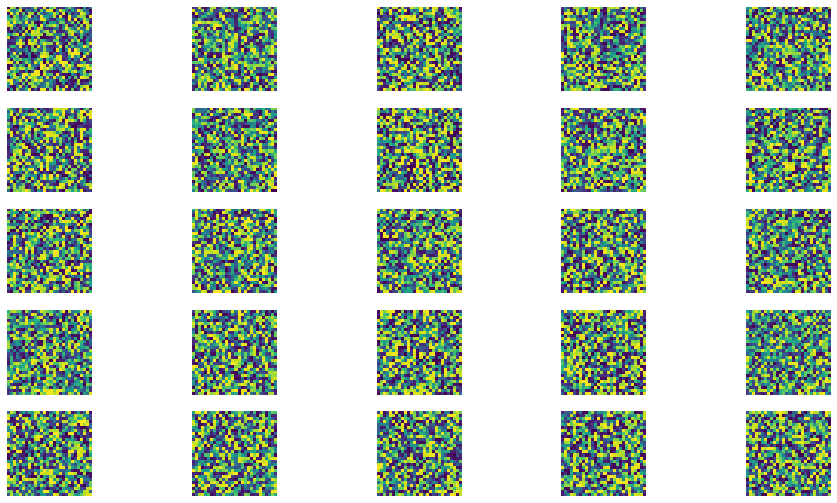

0 [D loss: 0.835378, acc.: 9.38%] [G loss: 0.631811]


/anaconda3/envs/tf/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


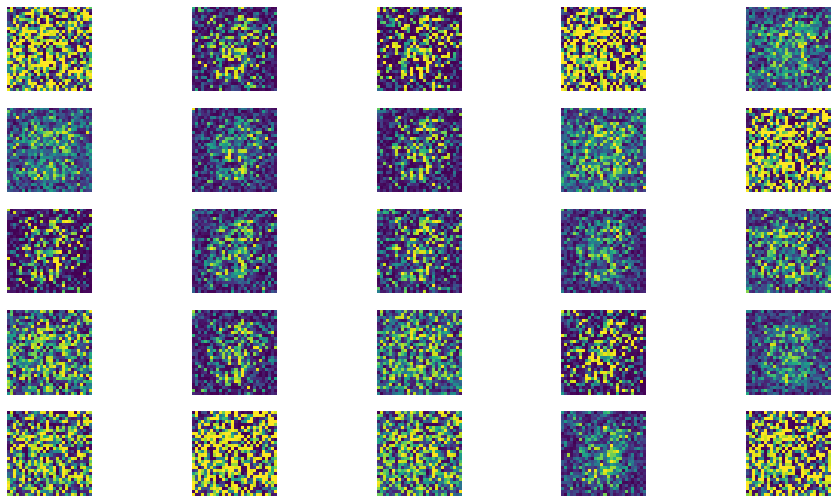

200 [D loss: 0.351039, acc.: 78.12%] [G loss: 2.664625]


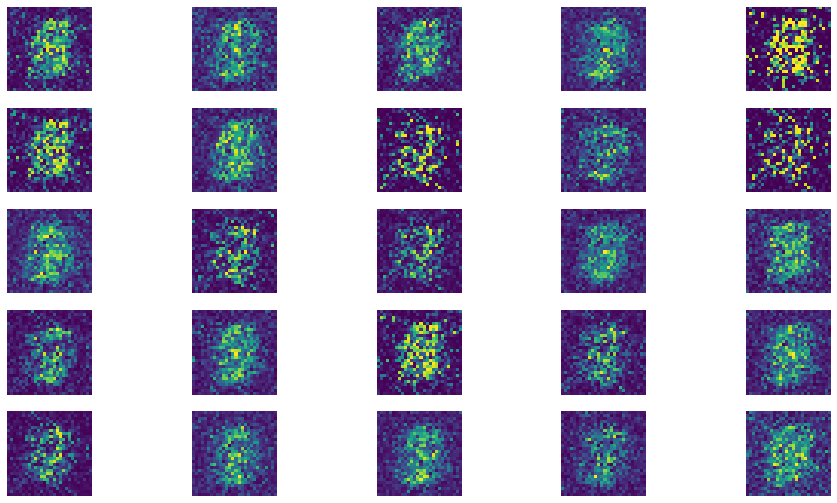

400 [D loss: 0.644403, acc.: 56.25%] [G loss: 0.702096]


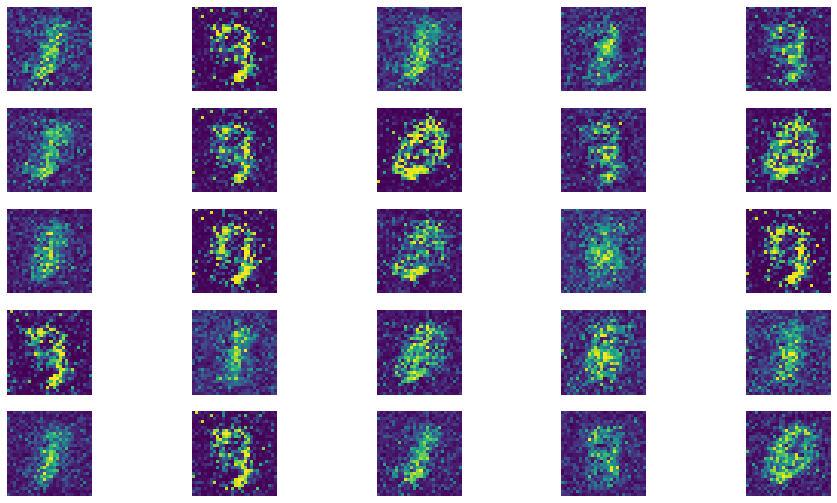

600 [D loss: 0.686583, acc.: 43.75%] [G loss: 0.753160]


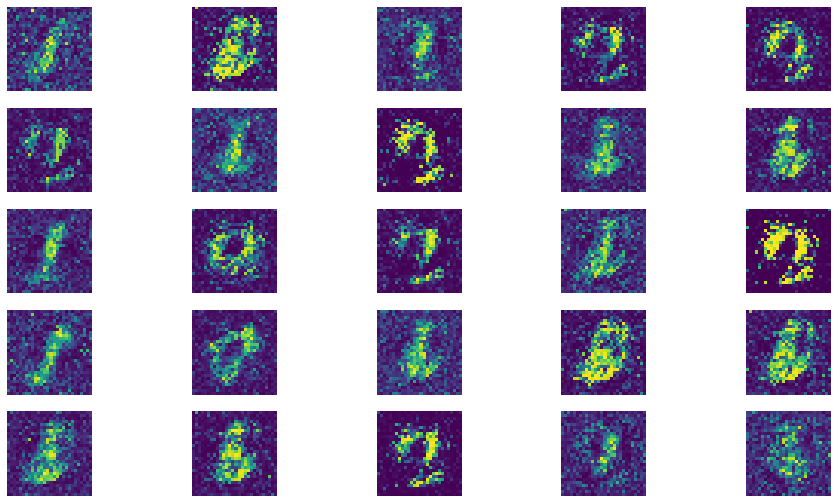

800 [D loss: 0.656960, acc.: 53.12%] [G loss: 0.836585]


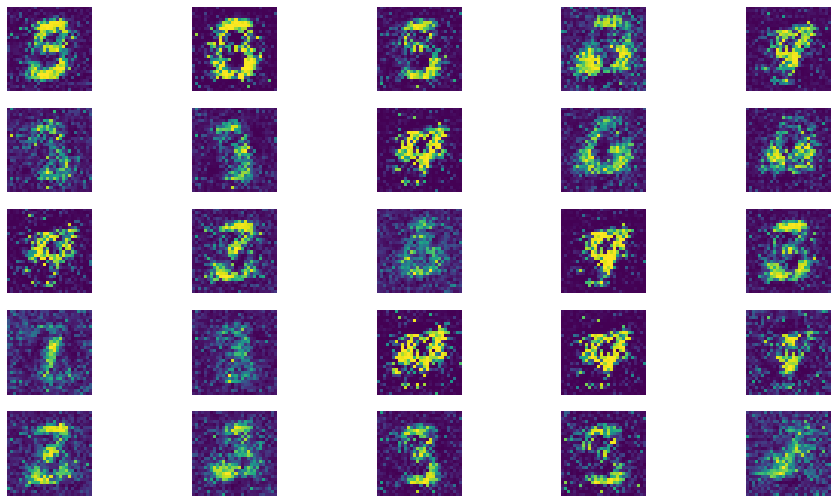

1000 [D loss: 0.695117, acc.: 62.50%] [G loss: 0.923617]


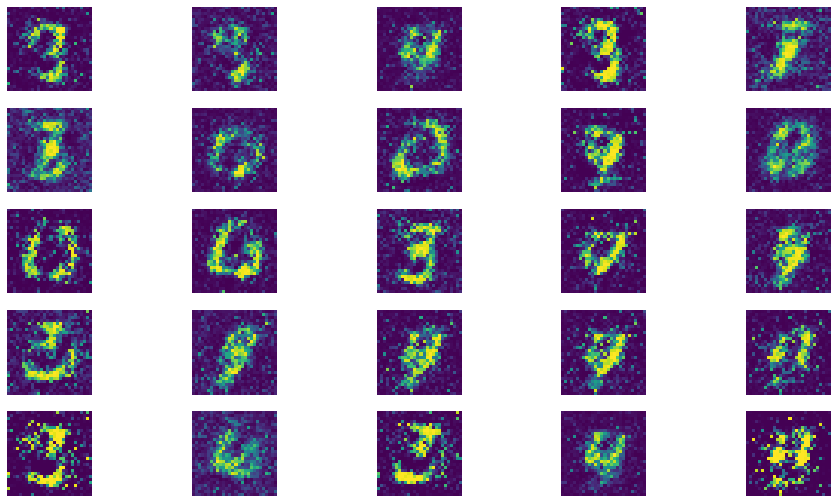

1200 [D loss: 0.584302, acc.: 71.88%] [G loss: 0.854774]


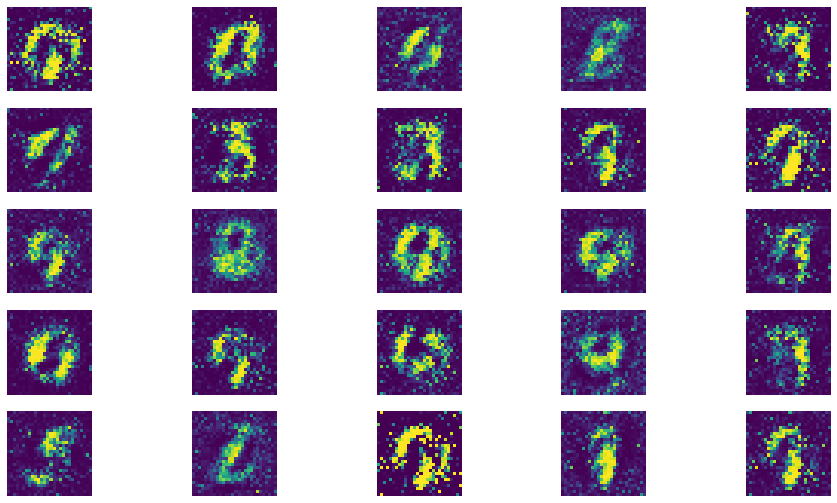

1400 [D loss: 0.621050, acc.: 65.62%] [G loss: 0.842692]


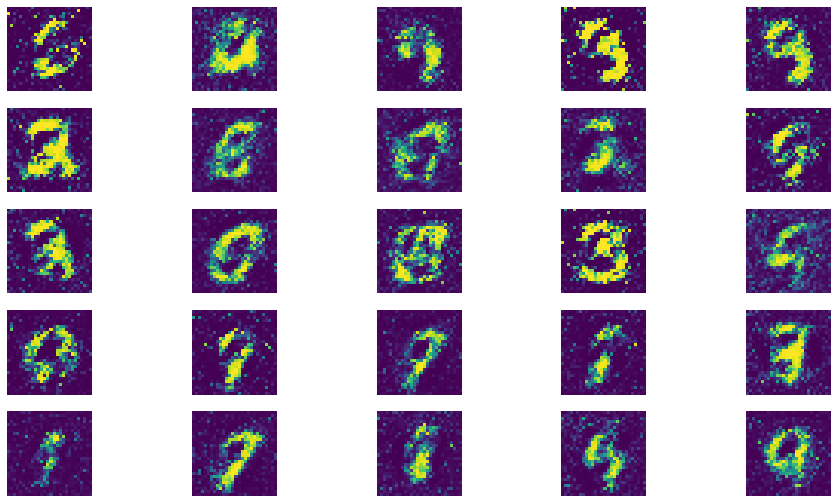

1600 [D loss: 0.603882, acc.: 62.50%] [G loss: 0.973179]


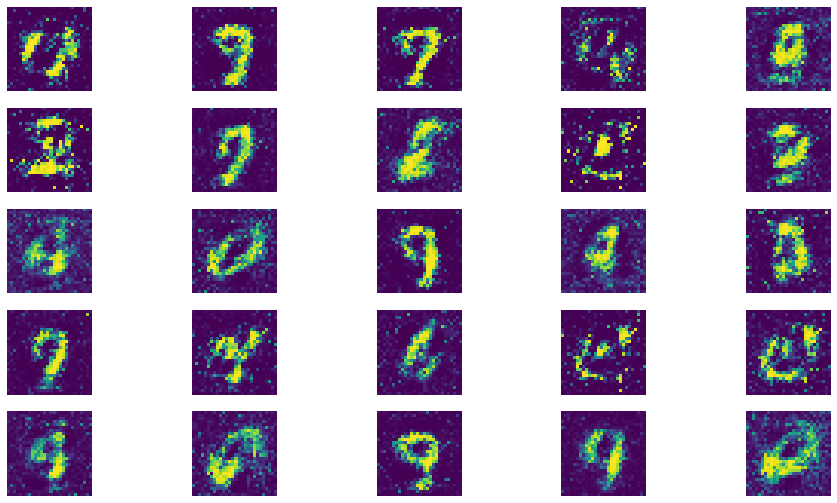

1800 [D loss: 0.520276, acc.: 90.62%] [G loss: 0.904419]


In [172]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        noise_shape = (100,)

        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                
                # Plot the progress
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c, figsize=(16,9))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
#         fig.savefig("gan/images/mnist_%d.png" % epoch)
#         plt.close()
        plt.show()
        


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=2000, batch_size=32, save_interval=200)

In [82]:
img_pr = gan.generator.predict(np.random.rand(5,100))

In [86]:
img_pr.shape

(5, 28, 28, 1)

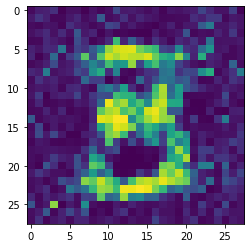

In [93]:
plt.imshow(img_pr[3].reshape(28,28))

## My version

In [186]:
# (*X_train.shape[1:],1)
np.expand_dims(X_train,axis=-1).shape
# X_train.shape
# np.repeat(np.zeros([5]),2)

(60000, 28, 28, 1)

============= 0 /10000 =============


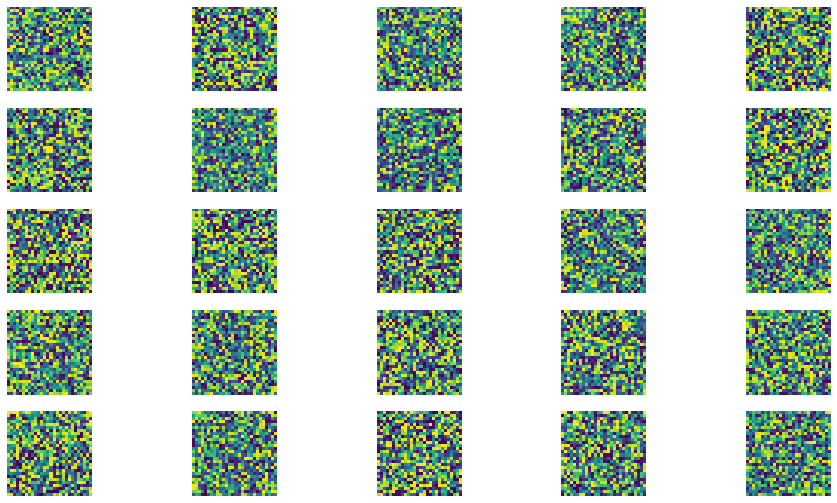

/anaconda3/envs/tf/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


============= 500 /10000 =============


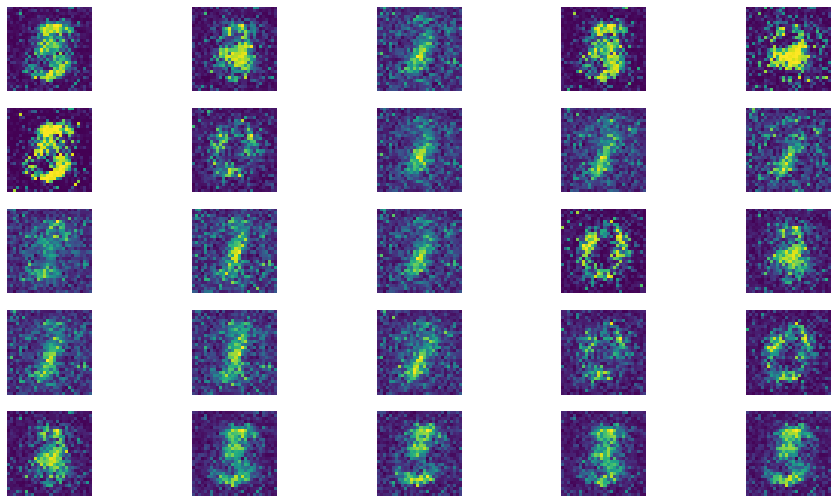

============= 1000 /10000 =============


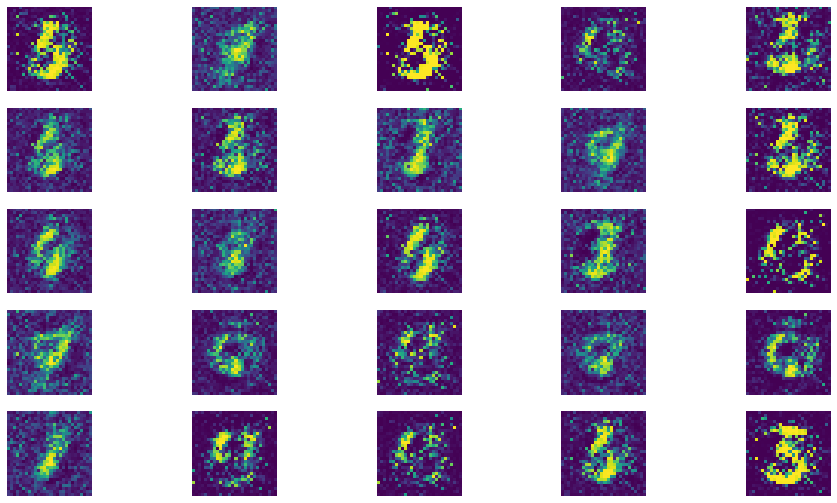

============= 1500 /10000 =============


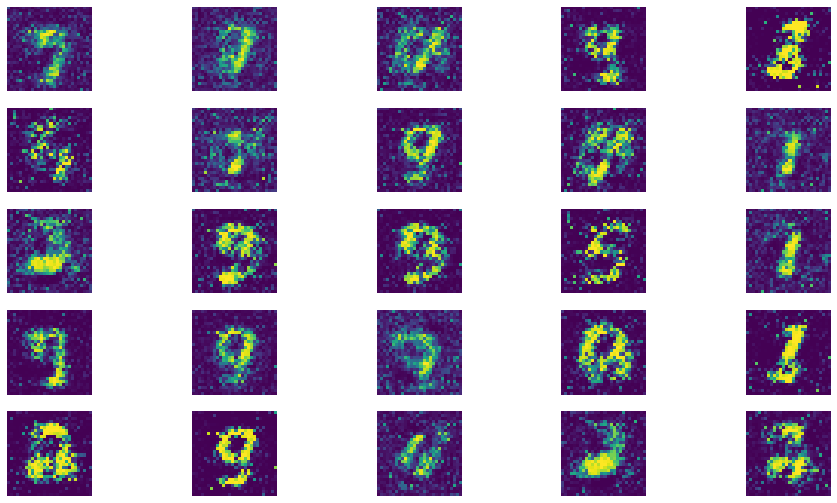

============= 2000 /10000 =============


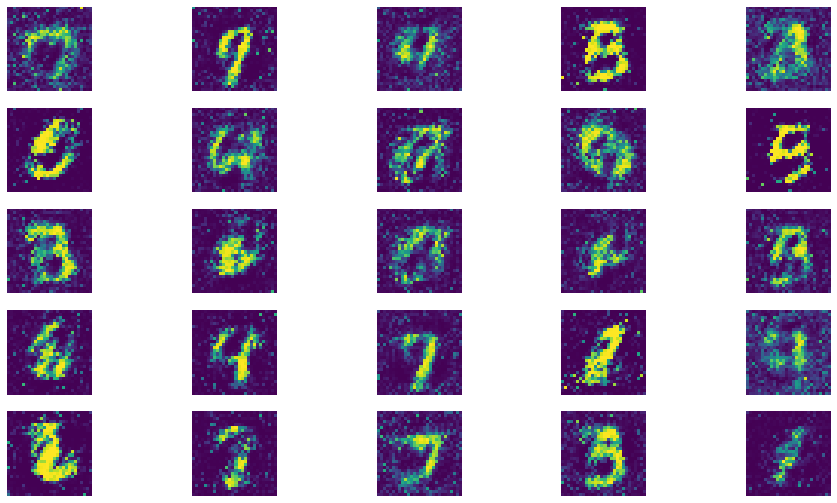

============= 2500 /10000 =============


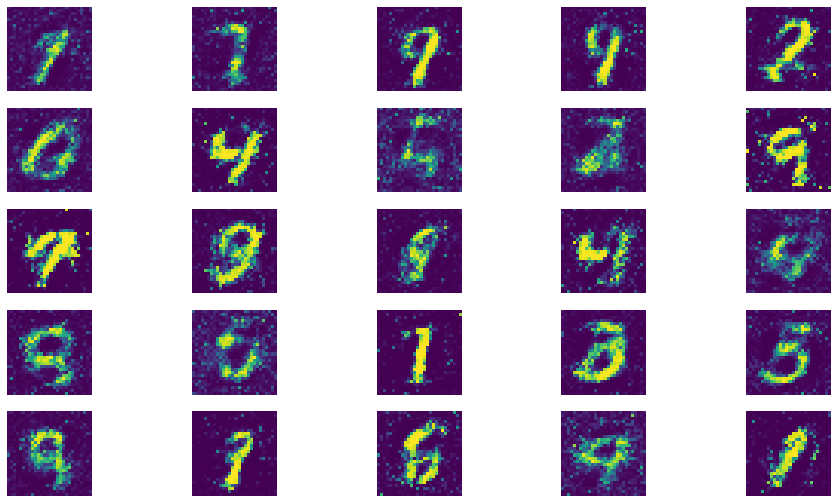

============= 3000 /10000 =============


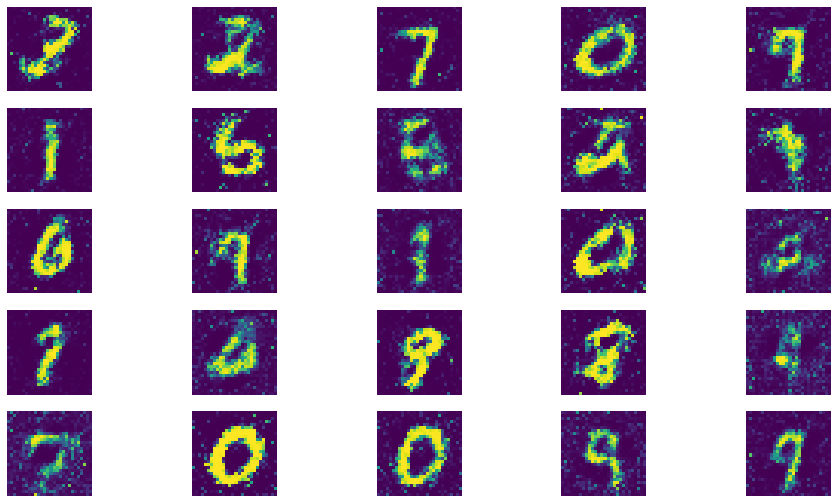

============= 3500 /10000 =============


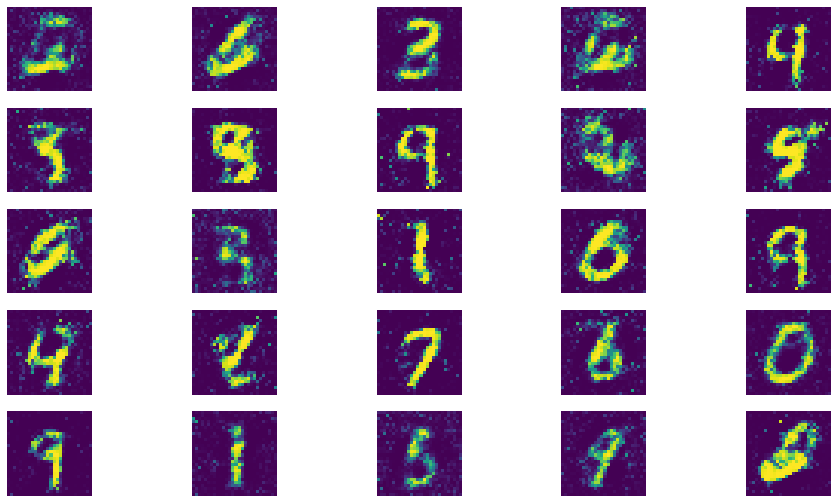

============= 4000 /10000 =============


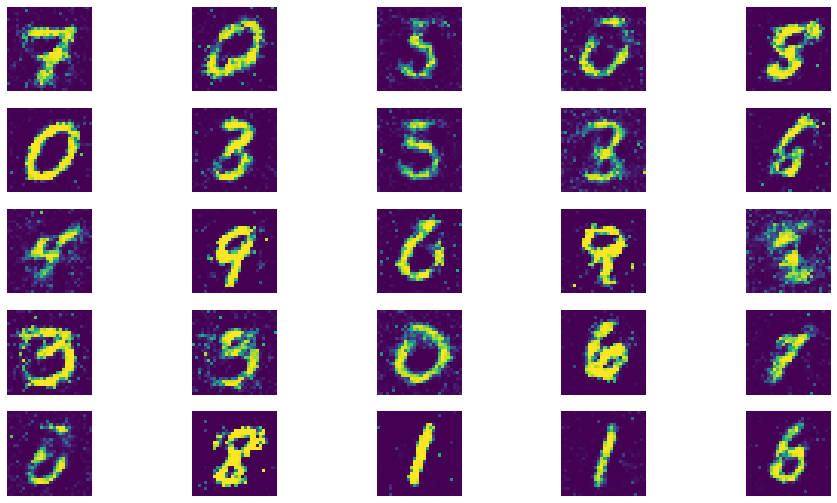

============= 4500 /10000 =============


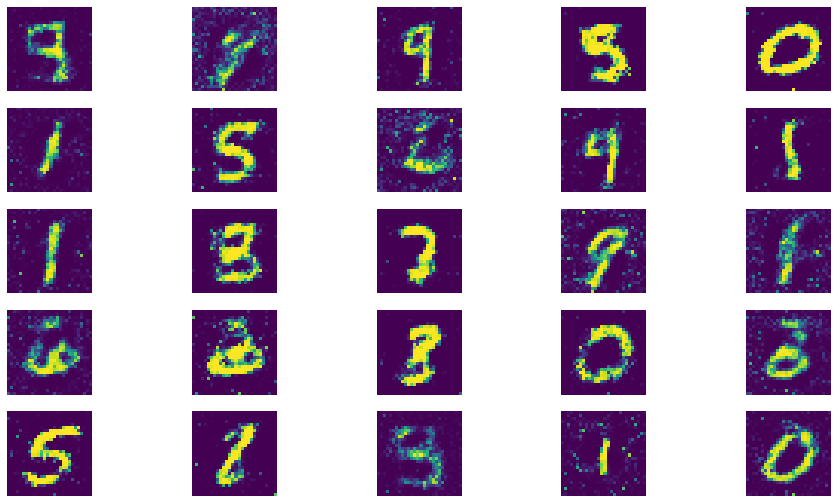

============= 5000 /10000 =============


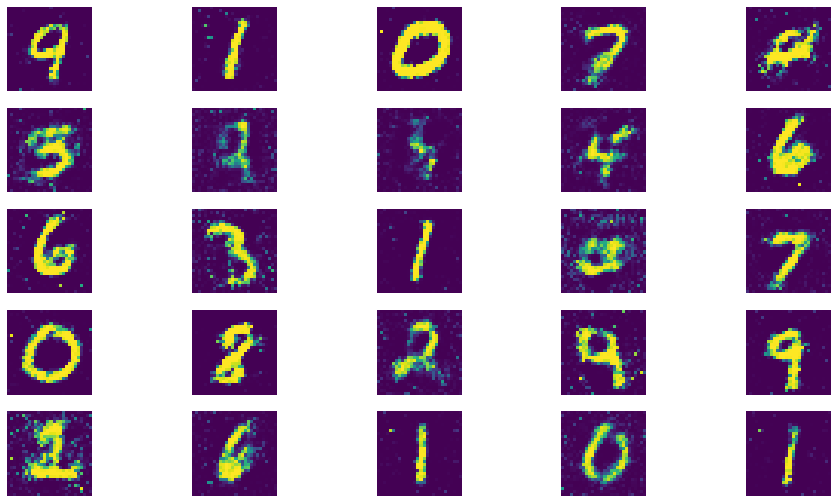

============= 5500 /10000 =============


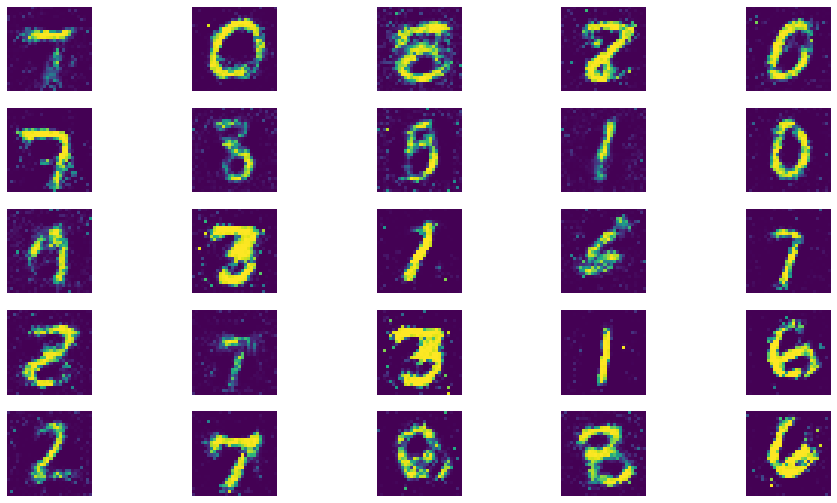

============= 6000 /10000 =============


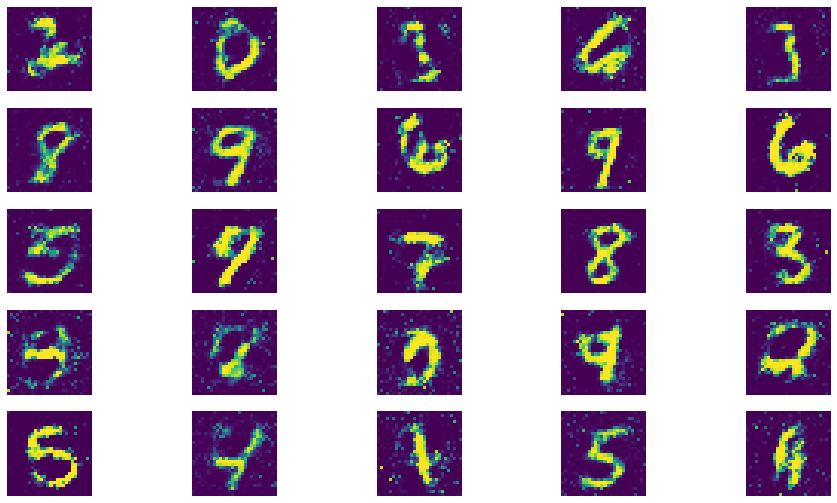

============= 6500 /10000 =============


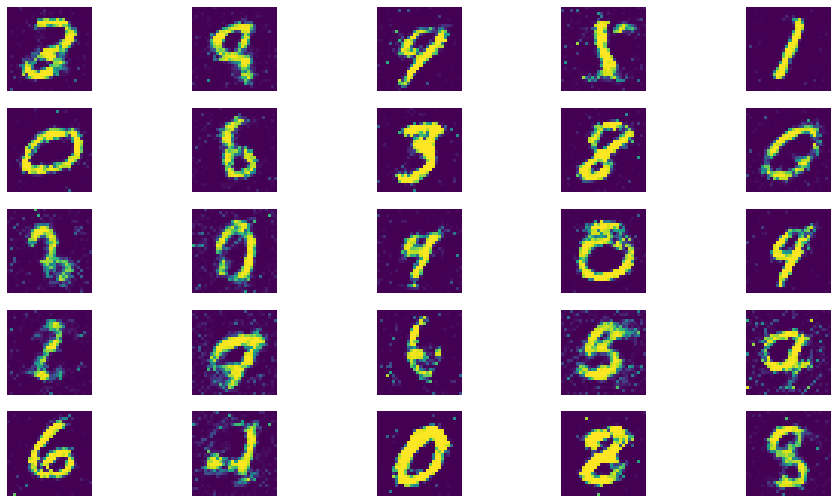

============= 7000 /10000 =============


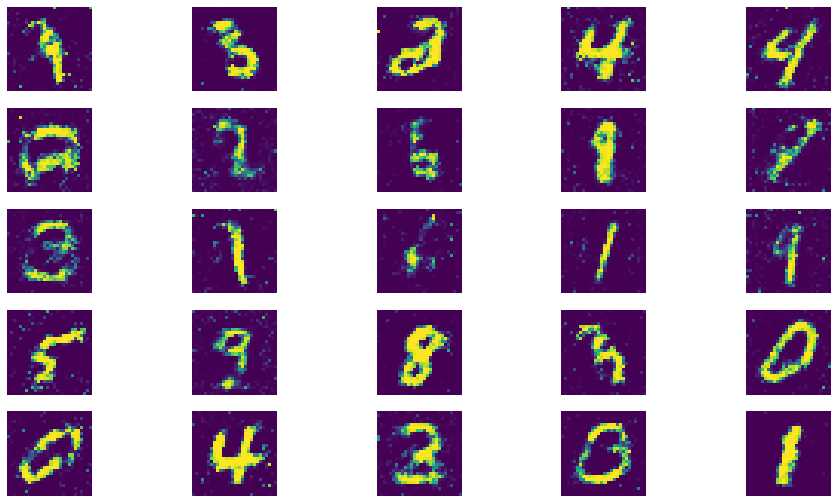

============= 7500 /10000 =============


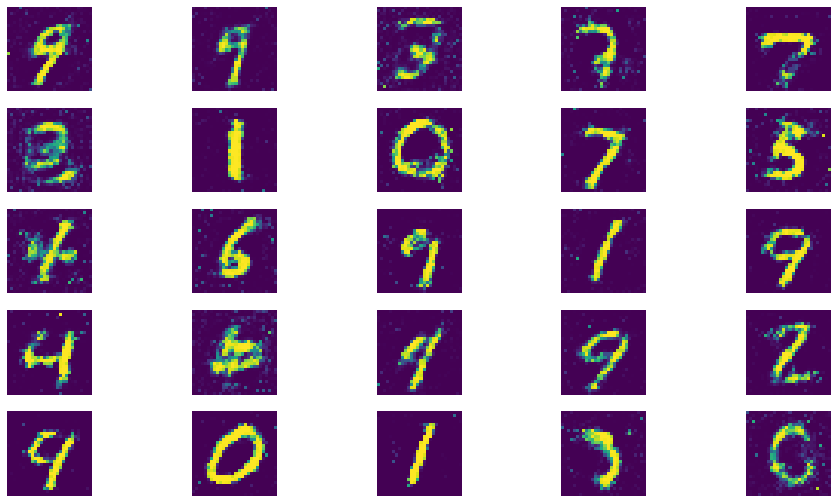

============= 8000 /10000 =============


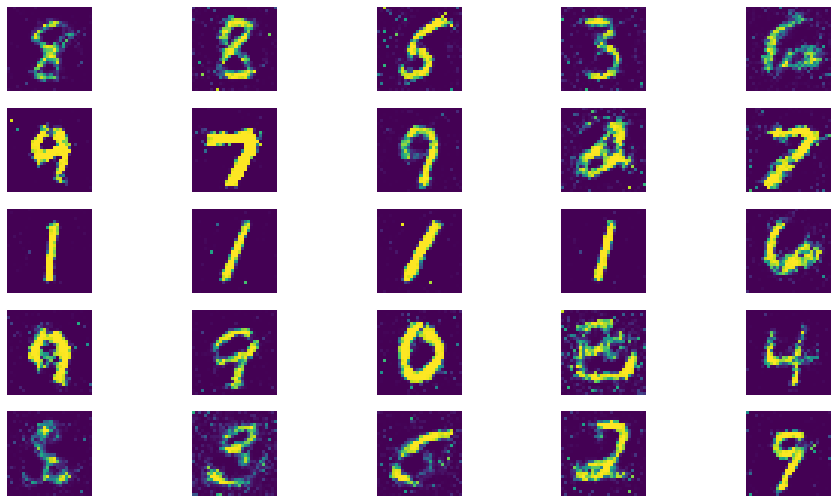

============= 8500 /10000 =============


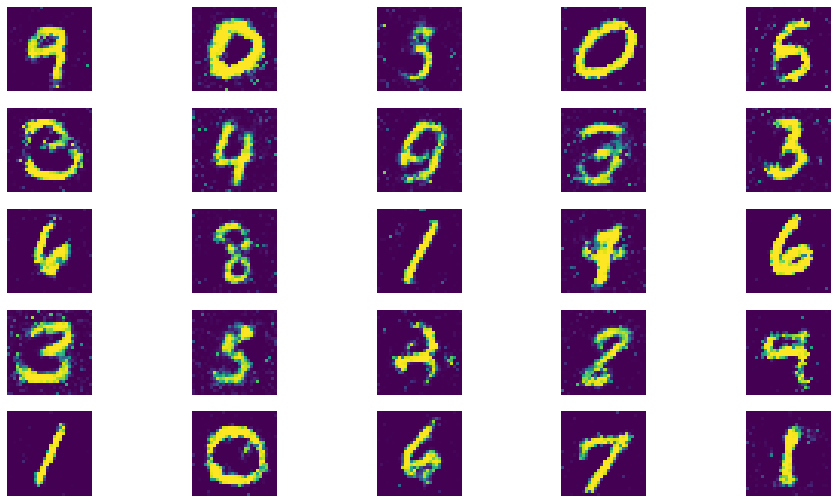

============= 9000 /10000 =============


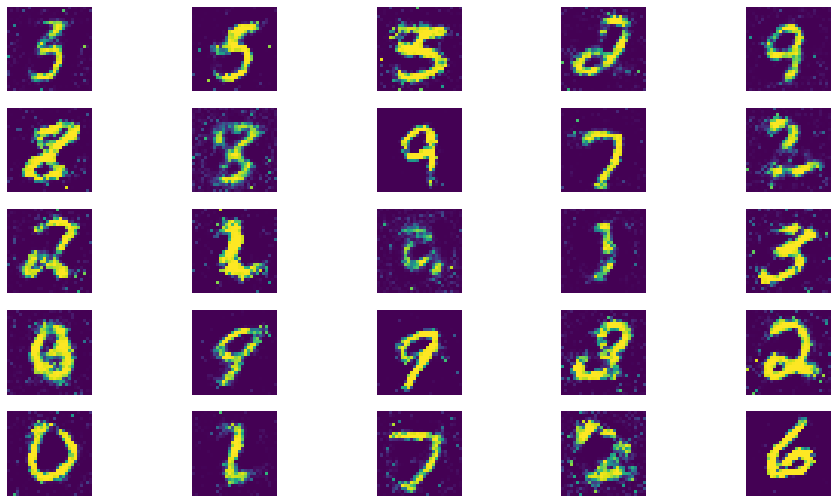

============= 9500 /10000 =============


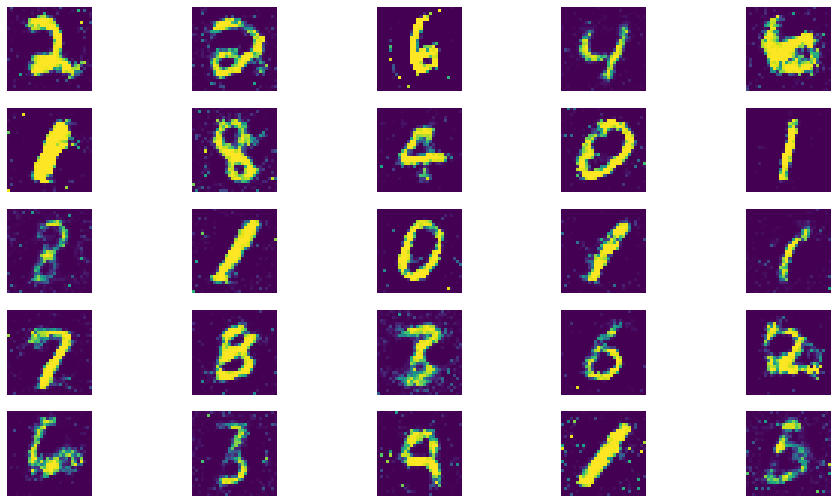

In [192]:
class GAN:
    def __init__(self, input_, batch_size=32, verbose=0):
        self.input_ = input_
        self.img_shape = (*input_.shape[1:],1)  # MNIST (28,28,1)
        self.batch_size = batch_size
        self.noise_shape = (100,)
        self.verbose = verbose
        self.optimizer = Adam(0.0002, 0.5)
        
        # Create generator
        self.generator=self._generator()
        self.generator.compile(loss="binary_crossentropy", optimizer=self.optimizer)
        
        # Create discriminator
        self.discriminator=self._discriminator()
        self.discriminator.compile(loss="binary_crossentropy", optimizer=self.optimizer, metrics=["acc"])
        
        # Create the whole gan
        self.discriminator.trainable = False
        self.noise = Input(shape=self.noise_shape)
        gen_img = self.generator(self.noise)
        prediction = self.discriminator(gen_img)
        
        self.combined = Model(self.noise, prediction)
        self.combined.compile(loss="binary_crossentropy", optimizer=self.optimizer, metrics=["acc"])
        
        
    def _generator(self):
        
        model = Sequential()
        model.add(Dense(256, input_shape=self.noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        if self.verbose:
            model.summary()

        noise = Input(shape=self.noise_shape)
        output = model(noise)
        
        return Model(noise,output)
        
    def _discriminator(self):
        
        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))

        if self.verbose:
            model.summary()
        
        image = Input(shape=self.img_shape)
        output = model(image)
        
        return Model(image,output)
        
        
    def train(self, epochs = 100):
        
        for e in range(epochs):
            
            half_batch = int(self.batch_size/2)
            
            index = np.random.randint(0,len(self.input_),size=half_batch)
            X_train = self.input_[index]
            X_train = X_train / 127.5 - 1.
            X_train = X_train.reshape(*X_train.shape,1)
            
            noise = np.random.normal(0,1,size=(half_batch, 100))
            
            # Get noise/image from generator
            gen_img = self.generator.predict(noise)
            
            # Train disriminator
            y_real = np.zeros([half_batch])
            y_fake = np.ones([half_batch])
#             self.discriminator.fit(X_train,y_real, verbose=0, batch_size=self.batch_size)
#             self.discriminator.fit(gen_img, y_fake, verbose=0, batch_size=self.batch_size)
            
            self.discriminator.train_on_batch(X_train,y_real)
            self.discriminator.train_on_batch(gen_img, y_fake)
  
            # Train generator in gan
            noise = np.random.normal(0,1,size=(self.batch_size, 100))
            self.combined.train_on_batch(noise, np.repeat(y_real,2))
            
            if e%500 == 0:
                print('=============',e,f'/{epochs} =============')
                self._plot_result()
        
        
    def _plot_result(self):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c, figsize=(16,9))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
#         fig.savefig("gan/images/mnist_%d.png" % epoch)
#         plt.close()
        plt.show()
        
(X_train, _), (_, _) = mnist.load_data()
gan = GAN(X_train, batch_size=128)
gan.train(10000)